# Setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, './venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [2]:
# model modules
from model import *

# used in the training loop
import time
from tools import *
import csv

# used to save & load models
import json
from dataclasses import asdict

# inference code
from inference import *

# Instantiate a brand new model

In [3]:
# tokenizer
from tokenizer import *
size = 1024 # size options are 128, 256, 512 and 1024
path = f'./tokenizers/tiny_stories_tokenizer_{size}.model'
tokenizer = get_tokenizer(path) 

# config file
from config import *
cfg = Config()
cfg.vocab_len = tokenizer.vocab_len
print(cfg)

Config(dim=64, vocab_len=1027, device='cpu', num_layers=12, pre_connect_dropout=False, second_resid_norm=True, mlp_hidden_mult=4, mlp_bias=True, mlp_nonlinearity='GeLU', mlp_gated=True, num_q_heads=4, num_kv_heads=1, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1)


In [4]:
model = customGPT(cfg).to(cfg.device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')
print(model)

914.496 K parameters
customGPT(
  (token_embedder): Embedding(1027, 64)
  (layers): ModuleList(
    (0-11): 12 x ResidualLayer(
      (pre_attn_norm): Norm()
      (attn): MQSA(
        (Wq): Linear(in_features=64, out_features=128, bias=False)
        (Wk): Linear(in_features=64, out_features=32, bias=False)
        (Wv): Linear(in_features=64, out_features=32, bias=False)
        (Wo): Linear(in_features=128, out_features=64, bias=False)
      )
      (post_attn_norm): Norm()
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wgate): Linear(in_features=64, out_features=256, bias=True)
        (Wup): Linear(in_features=64, out_features=256, bias=True)
        (Wdown): Linear(in_features=256, out_features=64, bias=True)
        (nonlinearity): GELU(approximate='none')
      )
      (post_mlp_norm): Norm()
    )
  )
  (final_norm): Norm()
  (criterion): CrossEntropyLoss()
)


# Training

In [5]:
batch_size = 32
train_data_loader = get_data_loader(batch_size=batch_size, split='train')
test_data_loader = get_data_loader(batch_size=batch_size, split='validation')

In [7]:
# maximum and minimum learning rate
lr_max = 1e-2
lr_min = 1e-5 # if you'd like a flat learning rate, set lr_max = lr_min and ignore the variables below

# Create a PyTorch optimizer
weight_decay = 0.02
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

# Training setup hyperparameters
max_iters = 20 # total number of batches to run over the course of training
warmup_iters = int(max_iters * 0.1) # if you don't want to use a lr warmup, set = 0
final_flat_iters = int(max_iters * 0.3) # if you don't want to use a final flat lr at the end, set = 0
num_restarts = 0 # if you don't want to use warm restarts, set =0
T_mult = 2 # if you want your warm restarts to all be the same length, set =1
anneal_type = 'cos' # type of annealment to use. options: 'cos' and 'lin'

# Calculates T_0 in a way that ensures smooth transition to the final flat learning rate
T_0 = (max_iters - warmup_iters - final_flat_iters) / sum(T_mult ** i for i in range(num_restarts+1))

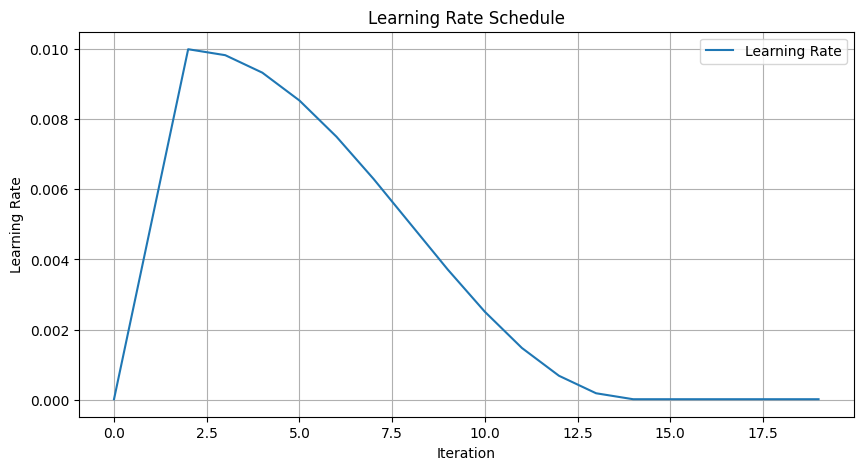

In [8]:
def scheduler_lambda(current_iter, debug=False):
    T_i = T_0
    if current_iter < warmup_iters:
        # Linear warmup
        lr = lr_min + (lr_max - lr_min) * (current_iter / warmup_iters)
    elif current_iter < max_iters - final_flat_iters:
        # Cosine annealing with warm restarts
        cycle_iter = current_iter - warmup_iters
        while cycle_iter >= T_i:
            cycle_iter -= T_i
            T_i *= T_mult
        if anneal_type == 'lin': 
            lr = lr_max - (lr_max - lr_min) * (cycle_iter / T_i)
        else:
            # defaults to 'cos' learning rate annealing
            lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + torch.cos(torch.pi * torch.tensor(cycle_iter / T_i)))
    else:
        # Constant learning rate
        lr = lr_min
    return lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_lambda)

if True: # set to true if you'd like to see a graph of the learning rate schedule
    import matplotlib.pyplot as plt
    
    # Generate learning rate values
    lrs = [scheduler_lambda(i) for i in range(max_iters)]
    
    # Plot the learning rates
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [8]:
if 'log_data' not in locals():
    log_data = []

# how often we want to check & see how our loss is doing
eval_interval = 5

start_time = time.time()

# Enable anomaly detection. uncomment these lines if you need to do extensive debugging
#torch.autograd.set_detect_anomaly(True)

for i in range(max_iters):

    # sample a batch of data
    batch = next(iter(train_data_loader))
    x,y = torcherize_batch(tokenizer, batch, cfg.max_seq_len, cfg.device)
    
    # train
    logits, loss = model(x, target_token_ids=y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Update the learning rate
    scheduler.step()
    
    # every once in a while evaluate the loss on train and val sets
    if i % eval_interval == 0 or i == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss(model, tokenizer, test_data_loader)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Collect data for CSV
        log_data.append([
            i,
            current_lr,
            losses['train'].mean().item(),
            losses['val'].mean().item(),
            torch.exp(losses['val']).mean().item(),
            elapsed_time,
            batch_size,
            weight_decay
        ])
        
        # Print data
        print(
            f"step {i:04d}: lr {current_lr:.6f}, train loss {losses['train'].mean().item():.4f}, "
            f"val loss {losses['val'].mean().item():.4f}, ppl {torch.exp(losses['val']).mean().item():.0f}, "
            f"time elapsed: {elapsed_time:.2f} seconds"
        )

# Disable anomaly detection after the training loop
#torch.autograd.set_detect_anomaly(False)

step 0000: lr 0.000099, train loss 43.5694, val loss 45.1347, ppl 51060176501824552960, time elapsed: 15.68 seconds
step 0005: lr 0.000061, train loss 37.6884, val loss 36.6616, ppl 10274963005112320, time elapsed: 65.63 seconds
step 0010: lr 0.000011, train loss 34.8425, val loss 35.6291, ppl 3020125171089408, time elapsed: 107.81 seconds
step 0015: lr 0.000000, train loss 34.8761, val loss 34.9023, ppl 1834013446635520, time elapsed: 166.36 seconds
step 0019: lr 0.000000, train loss 35.0908, val loss 34.6983, ppl 1562290193170432, time elapsed: 219.00 seconds


# inference test before you decide to save it

In [8]:
prompt = "Once"
model.eval()
output = generate(
    prompt, 
    model, 
    tokenizer,
    #max_gen_len = 512,
    temperature = 0.7,
    #memory_saver_div = 8,
    #top_p = 0.9,
    #top_k = 32,
)
model.train()
print(output)

Once and  JaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJaneJa

# Saving your model

In [9]:
name = f'models/{model.__class__.__name__}_{time.strftime("%Y-%m-%d|%H-%M")}.csv'

# Save training data to CSV
with open(name, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Step', 'Learning Rate', 'Train Loss', 'Validation Loss', 'Perplexity', 'Time Elapsed', 'Batch Size', 'Weight Decay'])
    writer.writerows(log_data)

# saving model
torch.save(model.state_dict(), f'{name}.pth')

# saving config
cfg_dict = asdict(cfg)
with open(f'{name}.json', 'w') as f:
    json.dump(cfg_dict, f)